## Perception Algorithm

#### Introduction
The Perceptron is one of the simplest types of artificial neural networks. It serves as a linear binary classifier, meaning it attempts to separate data into two parts using a straight line (in 2D), plane (in 3D), or hyperplane (in higher dimensions).

The Perceptron algorithm is inspired by the way neurons work in the human brain. It makes a decision by weighing input features, summing them up, and passing the result through an activation function.

#### How it Works
A perceptron takes several binary inputs, applies individual weights to them, sums the result, and then passes it through a step activation function to determine the output.


**Sumation function:**
$$
z = \sum_{i=1}^{n} w_i x_i + b
$$

**Activation (step) function:**
$$
\text{Output} =
\begin{cases}
1 & \text{if } z \geq 0 \\
-1 & \text{if } z < 0
\end{cases}
$$

This function determines whether the neuron “fires” or not.

#### Dataset

This notebook uses data from the **General Social Survey (GSS) 2018**, a long-running sociological survey administered by the National Opinion Research Center (NORC) at the University of Chicago. The GSS is one of the most widely used sources of data for understanding social trends in the United States, collecting opinions, behaviors, and demographic characteristics of U.S. adults since 1972.

For this analysis, we isolate three key variables that relate to subjective well-being:

- **HAPPY**: Respondents’ reported level of happiness. The original variable contains three responses:
  - 1 = Very Happy
  - 2 = Pretty Happy
  - 3 = Not Too Happy  
  We restrict our analysis to a binary classification task by selecting only the first two categories. This allows us to apply a linear model like the Perceptron more effectively without distorting the ordinal nature of the original variable.

- **HEALTH**: Self-rated health status, with responses ranging from:
  - 1 = Excellent
  - 2 = Good
  - 3 = Fair
  - 4 = Poor  
  This variable is a proxy for the respondent’s perceived physical well-being and is known to correlate with life satisfaction across many sociological studies.

- **SATFIN**: Satisfaction with financial situation, which captures economic self-assessment:
  - 1 = Pretty Satisfied
  - 2 = More or Less Satisfied
  - 3 = Not at All Satisfied  
  This variable provides an approximate sense of the respondent’s financial security or distress, which is also a strong predictor of happiness in empirical literature.

We drop any rows with missing values and limit the outcome to a binary label for simplification. These features were selected because they have clear theoretical relationships to happiness, are easy to interpret, and are commonly used in social science modeling of subjective well-being.

While this preprocessing simplifies the problem for educational purposes, the broader GSS dataset includes hundreds of other variables — such as political views, religious affiliation, education, income, family background, and geographic location — that could be used to construct more complex models of happiness and well-being.


### Import Required Libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Load and Clean Data

In [11]:
df = pd.read_csv("General Social Survey_2018.csv")
df = df[["HAPPY", "HEALTH", "SATFIN"]]
df = df.dropna()
df = df[df['HAPPY'].isin([1, 2])]  # 1 = Very Happy, 2 = Pretty Happy

### Data Preparation and Binary Label Conversion
In this step, we prepare the features and labels for training the Perceptron model. Specifically, we select two features from the GSS dataset:

`HEALTH`: Self-rated health status<br>
`SATFIN`: Satisfaction with financial situation<br>
These features are stored in matrix `X`, while the target variable `HAPPY` serves as the label. Since the Perceptron is a binary classifier, we simplify the multiclass `HAPPY` column into a binary format:

`1` (Very Happy) is treated as the positive class.
All other responses (e.g., Pretty Happy, Not Too Happy) are treated as the negative class (`0`).
We then split the dataset into training and testing sets using an 80/20 ratio. This allows the model to learn from the training data and be evaluated on unseen test data for generalization performance. The `random_state=42` ensures reproducibility.

In [47]:
X = df[["HEALTH", "SATFIN"]]
y = df["HAPPY"]

# Convert labels to binary: 1 = Very Happy, 0 = Pretty Happy
y = (y == 1).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Data Visualization by Label

Below is a scatterplot showing how self-reported health and financial satisfaction relate to reported happiness levels.

- Blue dots represent respondents who identified as **"Very Happy"**.
- Red dots represent those who said they were **"Pretty Happy"**.

We expect to see clustering patterns, such as higher happiness among those with better health (lower scores) and higher financial satisfaction (also lower scores). However, the classes are slightly imbalanced and the overlap reflects the complexity of modeling subjective well-being with just two variables.

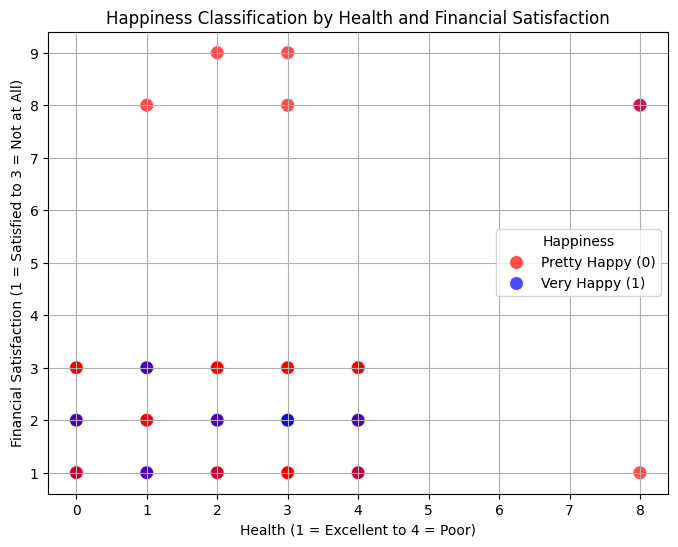

In [49]:
plot_df = X.copy()
plot_df['HAPPY'] = y

custom_palette = {0: 'red', 1: 'blue'}

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=plot_df,
    x='HEALTH',
    y='SATFIN',
    hue='HAPPY',
    palette=custom_palette,
    s=100,
    alpha=0.7
)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=["Pretty Happy (0)", "Very Happy (1)"], title="Happiness")

plt.xlabel('Health (1 = Excellent to 4 = Poor)')
plt.ylabel('Financial Satisfaction (1 = Satisfied to 3 = Not at All)')
plt.title('Happiness Classification by Health and Financial Satisfaction')
plt.grid(True)
plt.show()

### Building the Perceptron Classifier

In this step, we implement the Perceptron algorithm manually using Python. 

This class includes the following components:

- `__init__`: Initializes key hyperparameters such as the learning rate and number of iterations (epochs), along with placeholders for the weights and bias.
- `fit(X, y)`: Trains the model on input features `X` and binary target `y` by iteratively adjusting weights and bias based on the **Perceptron learning rule**:
  
  $$ \text{update} = \eta \cdot (y_i - \hat{y}_i) $$

  where $\eta$ is the learning rate, $y_i$ is the true label, and $\hat{y}_i$ is the predicted label.

- `predict(X)`: Uses the trained weights and bias to compute predictions for unseen data.
- `_unit_step_func(x)`: The activation function that converts continuous outputs into binary predictions (0 or 1) using a step function:

  $$
  \text{output} = 
  \begin{cases}
  1 & \text{if } x \geq 0 \\
  0 & \text{otherwise}
  \end{cases}
  $$

This structure allows us to train and evaluate a linear binary classifier that makes decisions based on a weighted sum of the inputs.


In [51]:
class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.activation_func = self._unit_step_func
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.epochs):
            for idx, x_i in enumerate(X):
                linear_output = np.dot(x_i, self.weights) + self.bias
                y_predicted = self.activation_func(linear_output)
                update = self.lr * (y[idx] - y_predicted)
                self.weights += update * x_i
                self.bias += update

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        y_predicted = self.activation_func(linear_output)
        return y_predicted

    def _unit_step_func(self, x):
        return np.where(x >= 0, 1, 0)

### Initializing and Training the Perceptron Model

With our `Perceptron` class defined, we now initialize an instance of the model with a **learning rate** of `0.01` and train it over `1000` iterations (epochs).

- `learning_rate=0.01` controls how much the weights are adjusted during each step of training. A smaller value ensures more gradual learning, which can improve stability.
- `epochs=1000` defines how many times the algorithm will pass through the training dataset to update the weights.

The `.fit()` method is then called with the training features and labels to begin the learning process. We use `.values` to ensure that the input to the Perceptron is in NumPy array format, which the class expects.


In [53]:
ppn = Perceptron(learning_rate=0.01, epochs=1000)
ppn.fit(X_train.values, y_train.values)

### Model Evaluation: Predictions and Performance Metrics

After training the Perceptron model, we evaluate its performance on the unseen **test dataset**:

- `ppn.predict(X_test.values)` generates predicted labels for the test set.
- `classification_report(y_test, y_pred)` provides key evaluation metrics, including:
  - **Precision**: the proportion of positive predictions that were actually correct.
  - **Recall**: the proportion of actual positives that were correctly identified.
  - **F1-score**: the harmonic mean of precision and recall, giving a balanced measure.

To visualize the model's performance, we generate a **confusion matrix**, which shows:
- True Positives (correct positive predictions),
- True Negatives (correct negative predictions),
- False Positives (incorrect positive predictions),
- False Negatives (incorrect negative predictions).



Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.90      0.77       268
           1       0.44      0.16      0.24       134

    accuracy                           0.65       402
   macro avg       0.56      0.53      0.51       402
weighted avg       0.60      0.65      0.60       402



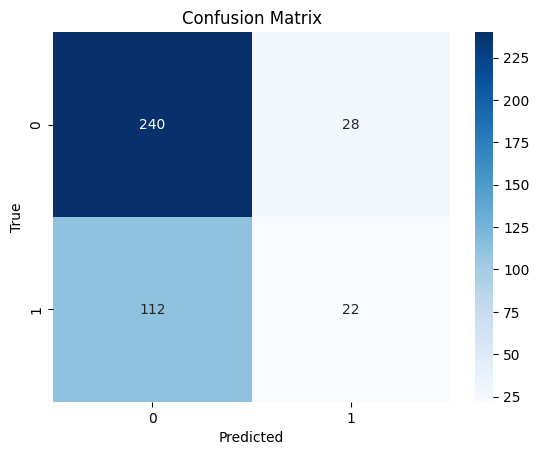

In [55]:
y_pred = ppn.predict(X_test.values)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Conclusions and Evaluation

The Perceptron classifier achieved an overall **accuracy of 65%** on the test set. However, accuracy alone is misleading in this case due to the imbalance between the two classes (268 "Pretty Happy" vs. 134 "Very Happy").

Key takeaways from the classification report and confusion matrix:

- **High recall for 'Pretty Happy' (0)**: The model correctly identified 90% of the "Pretty Happy" respondents.
- **Poor recall for 'Very Happy' (1)**: Only 16% of the "Very Happy" cases were correctly predicted, meaning the model struggled to distinguish the minority class.
- **F1-Score disparity**: The F1 score for "Pretty Happy" was strong (0.77), but only 0.24 for "Very Happy," confirming the model is biased toward the majority class.
- **Confusion Matrix**:
  - 240 true negatives (correctly predicted 0)
  - 28 false positives (predicted 1 when actually 0)
  - 112 false negatives (missed "Very Happy" predictions)
  - Only 22 true positives

This suggests that the Perceptron, being a linear classifier, is not well-suited for separating the "Very Happy" group using just `HEALTH` and `SATFIN`. A more complex or nonlinear model (e.g., logistic regression with regularization, SVM, or decision tree) might capture subtler patterns.

We can evaluate model performance using:
- **Precision and recall tradeoffs** to measure balance between false positives and false negatives.
- **F1-score** to reflect overall usefulness for each class.
- **Class imbalance awareness** to interpret results in context.

#### Limitations

- **Binary simplification:** Collapsing happiness into just two categories may lose nuance in responses.
- **Subjectivity:** Variables like health and financial satisfaction are self-reported and subject to personal interpretation.
- **Sampling bias:** Though the GSS is representative, it may underrepresent some marginalized groups.
- **Feature limitation:** Using only two features limits classification power. Additional variables could improve accuracy.
